In [21]:
from hcipy import *
from hcipy import atmosphere
from hcipy import fourier
import numpy as np
from matplotlib import pyplot as plt
import turb_sims as ts
from importlib import reload

## Defining the system
These cells define the sysem for us.

In [3]:
wavelength = 800.0e-9
Dtel = 6.5
pad = 2
Dgrid = 60/56 * Dtel
n_bin = 2 #this allows us to oversample our pupil
grid = make_pupil_grid(60*n_bin, Dgrid) # could suepersample this to stop aliasing errors
grid_pad = make_pupil_grid(60*n_bin*pad, Dgrid*pad)
wfs_grid = make_pupil_grid(120*n_bin, 2 * Dgrid)

In [4]:
# x and y should be zero
# width and height should be the Dgrid 
#its make_pupil_grid(pixels, size) 
h_pad = 60*n_bin*pad
h_reg = 60*n_bin

def window_field(field, new_grid, h, x0=0, y0=0):
    cropped_field = field.shaped[(y0-h//2):(y0+h//2), (x0 - h//2):(x0+h//2)]
    return Field(cropped_field.ravel(), new_grid)

### setup WFS

In [5]:
# setting up the pyramid pwfs
pwfs = PyramidWavefrontSensorOptics(grid, wfs_grid, separation=Dgrid, pupil_diameter=Dtel, wavelength_0=wavelength, q=4) # q gives pixels per lambda over D
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3 * wavelength/Dtel, num_steps=20) #, fast_modulation_method=True) # had to exlude bc not on sebastiaans version

### setup telescope aperture

In [6]:
aperture = evaluate_supersampled(make_magellan_aperture(), grid, 8) # anti aliasing filter => softens filter
wf = Wavefront(aperture, wavelength)
wf.total_power = 1.0

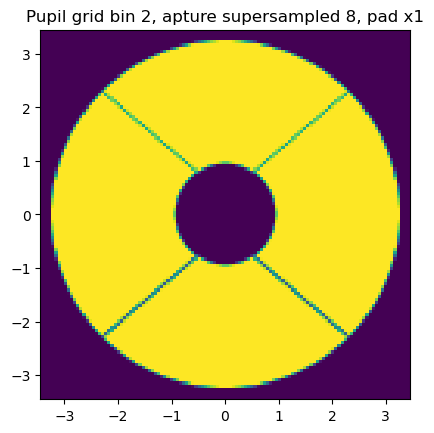

In [7]:
plt.figure()
plt.title(f"Pupil grid bin {n_bin}, apture supersampled 8, pad x{1}")
imshow_field(aperture)
plt.show()

In [8]:
# shoing we can window down from 
aperture_pad = evaluate_supersampled(make_magellan_aperture(), grid_pad, 8) 
h_pad = 60*n_bin*pad
h_reg = 60*n_bin
crop_aperture = window_field(aperture_pad, grid, h_reg, x0=h_pad//2, y0=h_pad//2)

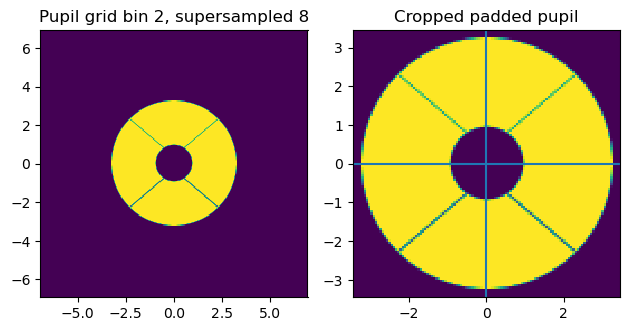

In [9]:
plt.subplot(1,2,1)
plt.title(f"Pupil grid bin {n_bin}, supersampled 8")
imshow_field(aperture_pad)

plt.subplot(1,2,2)
plt.title(f"Cropped padded pupil")
imshow_field(crop_aperture)
plt.axhline(0)
plt.axvline(0)

plt.tight_layout()
plt.show()


### Control basis

In [10]:
zmodes = make_zernike_basis(200, Dtel, grid, 2)
dm = DeformableMirror(zmodes)

### Make interaction matrix

In [11]:
# Illumination reference
Iref = 0
for wfi in mpwfs(wf):
	Iref += wfi.power
Iref /= 20
Iref_bin = subsample_field(Iref, n_bin)

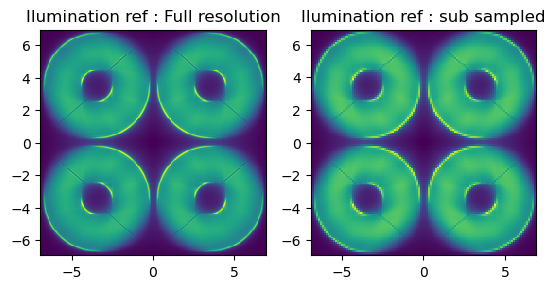

In [12]:
#showing the Reference
plt.subplot(1,2,1)
plt.title("Ilumination ref : Full resolution")
imshow_field(Iref)
plt.subplot(1,2,2)
plt.title("Ilumination ref : sub sampled")
imshow_field(Iref_bin)
plt.show()

In [14]:
#### SLOPES 
# Right now, working without regularizations
# Slopes are an tranversed slopes

calibration_amplitude = 10e-9
dm.flatten()

slopes = []
for i in range(dm.num_actuators):
	if i % 10 == 0:
		print("Calibrating mode {:d}".format(i))

	slope = 0
	for s in [-1, 1]:
		dm.actuators[i] += s * calibration_amplitude

		im = 0		
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /=20
		im_binned = subsample_field(im, n_bin)

		slope += s * im_binned / (2 * calibration_amplitude)

		dm.actuators[i] -= s * calibration_amplitude
	slopes.append(slope)
# slopes to use, tranverse of images
slopes = np.array(slopes).T
# reconstruction matrix from inverse tikhonov
reconstruction_matrix = inverse_tikhonov(slopes,1e-3)

Calibrating mode 0


Calibrating mode 10
Calibrating mode 20
Calibrating mode 30
Calibrating mode 40
Calibrating mode 50
Calibrating mode 60
Calibrating mode 70
Calibrating mode 80
Calibrating mode 90
Calibrating mode 100
Calibrating mode 110
Calibrating mode 120
Calibrating mode 130
Calibrating mode 140
Calibrating mode 150
Calibrating mode 160
Calibrating mode 170
Calibrating mode 180
Calibrating mode 190


In [13]:
# save slopes matrix
np.save("save/slopes", slopes)

NameError: name 'slopes' is not defined

In [14]:
# load slopes matrix
slopes = np.load("save/slopes.npy")

#### Filtering stuff

In [15]:
# number of illuminated actuators: 48
# q is our zero padding. we're at 4 now probably need to increase
ff = FourierFilter(grid, make_circular_aperture(2 * np.pi * 48 / Dtel), q=4)
# rectangular aperture for a better description of the control region
ffs = FourierFilter(grid, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)

In [16]:
# number of illuminated actuators: 48
# q is our zero padding. we're at 4 now probably need to increase
ff = FourierFilter(grid, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)
ff_pad = FourierFilter(grid_pad, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)

In [17]:
# simplified aperture for minimizing funky ff residuals
circ_ap = evaluate_supersampled(make_circular_aperture(6.5), grid, 4)
circ_ap_pad = evaluate_supersampled(make_circular_aperture(6.5), grid_pad, 4)

## Testing Fourier filtering

### One phase screen test

#### Testing LCO vs. power law

In [ ]:
r_o = 0.10
# Using Las Capanas atmosphere (LCO)
phase_LCO, phase_filt_LCO, phase_res_LCO = ts.turb_phase(r_o, grid, ff, circ_ap, ao_eff=1.0)
# Power Law (PL)
phase_PL, phase_filt_PL, phase_res_PL = ts.turb_phase_PL_r0(r_o, circ_ap, ao_eff=1.0)

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [ ]:
print("Unfiltered Phase numbers")
# knoll 1976 - inf outer scale
knoll = np.sqrt(1.031*(6.5/r_o)**(5/3) ) * (500e-9/(2*np.pi))
# equivalent - WFE of unfiltered phase
WFE_raw = ts.phase_to_WFE(phase_LCO[circ_ap>0], wavelength)
WFE_raw_pl = ts.phase_to_WFE(phase_PL[circ_ap>0], wavelength)
#PRINT
print(f"Noll:       {knoll*1e9:.3} nm")
print(f"WFE:        {WFE_raw*1e9:.3} nm")
print(f"WFE PL:    {WFE_raw_pl*1e9:.3} nm")

Unfiltered Phase numbers
Noll:       2.62e+03 nm
WFE:        2.36e+03 nm
WFE PL:    7.04e-06 nm


In [ ]:
# uhh, can I get an RMS from this?
wfe_res = ts.phase_to_WFE(phase_res_LCO[circ_ap>0], wavelength)
wfe_res_pl = ts.phase_to_WFE(phase_res_PL[circ_ap>0], wavelength)
#Hudgens fitting number in nm
hudgens = np.sqrt(0.28*(.135/r_o)**(5/3) ) * (500e-9/(2*np.pi))

print("r_o: ", r_o)
print(f"DIMM: {ro_to_seeing(r_o):.3}")
print(f"Hudgens: {hudgens*1e9:.3}nm")
print(f"WFE:     {wfe_res*1e9:.3} nm")
print(f"WFE PL: {wfe_res_pl*1e9:.3} nm")

r_o:  0.1
DIMM: 1.01
Hudgens: 54.1nm
WFE:     1.64e+02 nm
WFE PL: 4.73e-07 nm


#### testing single layer

In [ ]:
r_o = 0.10
# Using Las Capanas atmosphere (LCO)
phase, phase_filt, phase_res = ts.turb_phase(r_o, grid, ff, circ_ap, ao_eff=1.0,  L0=25)
# Power Law (PL)
phase_PL, phase_filt_PL, phase_res_PL = ts.turb_phase_sl(r_o, grid, ff, circ_ap, ao_eff=1.0, L0=25)

In [ ]:
print("Unfiltered Phase numbers")
# knoll 1976 - inf outer scale
noll = np.sqrt(1.031*(6.5/r_o)**(5/3) ) * (500e-9/(2*np.pi))
# equivalent - WFE of unfiltered phase
WFE_raw = ts.phase_to_WFE(phase[circ_ap>0], wavelength)
WFE_raw_pl = ts.phase_to_WFE(phase_PL[circ_ap>0], wavelength)
#PRINT
print(f"Noll:       {noll*1e9:.3} nm")
print(f"WFE ML:        {WFE_raw*1e9:.3} nm")
print(f"WFE SL:    {WFE_raw_pl*1e9:.3} nm")

Unfiltered Phase numbers
Noll:       2.62e+03 nm
WFE ML:        1.73e+03 nm
WFE SL:    1.96e+03 nm


In [ ]:
# uhh, can I get an RMS from this?
wfe_res = ts.phase_to_WFE(phase_res[circ_ap>0], wavelength)
wfe_res_pl = ts.phase_to_WFE(phase_res_PL[circ_ap>0], wavelength)
#Hudgens fitting number in nm
hudgens = np.sqrt(0.28*(.135/r_o)**(5/3) ) * (500e-9/(2*np.pi))

print("r_o: ", r_o)
print(f"DIMM: {ts.ro_to_seeing(r_o):.3}")
print(f"Hudgens: {hudgens*1e9:.3}nm")
print(f"WFE ML:     {wfe_res*1e9:.3} nm")
print(f"WFE SL: {wfe_res_pl*1e9:.3} nm")

r_o:  0.1
DIMM: 1.01
Hudgens: 54.1nm
WFE ML:     51.0 nm
WFE SL: 50.1 nm


##### testing ML SL multiple trials

In [ ]:
phase_WFE_SL_list = []
phase_WFE_ML_list = []
phase_res_WFE_SL_list = []
phase_res_WFE_ML_list = []

L0_test = 500

for i in range(50):
    # using the multilayer atmosphere
    phase, phase_filt, phase_res = ts.turb_phase(r_o, grid, ff, circ_ap, ao_eff=1.0,  L0=L0_test)
    # using the single layer atmosphere
    phase_crop, phase_filt_crop, phase_res_crop = ts.turb_phase_sl(r_o, grid, ff, circ_ap, ao_eff=1.0, L0=L0_test)
    # calc WFE
    WFE_raw = ts.phase_to_WFE(phase[circ_ap>0], wavelength)
    WFE_raw_pd = ts.phase_to_WFE(phase_crop[circ_ap>0], wavelength)
    wfe_res = ts.phase_to_WFE(phase_res[circ_ap>0], wavelength)
    wfe_res_pd = ts.phase_to_WFE(phase_res_crop[circ_ap>0], wavelength)
    #add to the lists
    phase_WFE_SL_list.append(WFE_raw)
    phase_WFE_ML_list.append(WFE_raw_pd)
    phase_res_WFE_SL_list.append(wfe_res)
    phase_res_WFE_ML_list.append(wfe_res_pd)
    

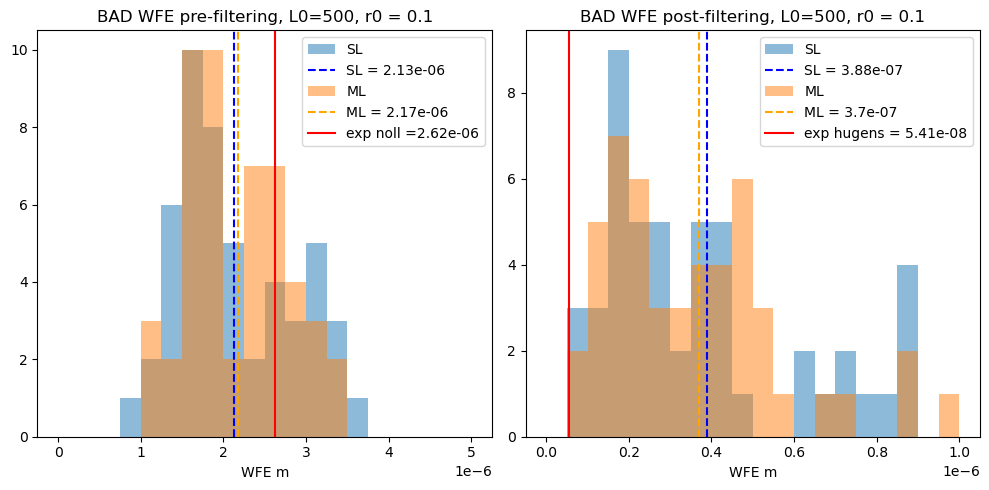

In [ ]:
# compare the two:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

bins1 = np.linspace(0e-7, 50e-7, 21)
bins2 = np.linspace(0e-8, 10e-7, 21)

plt.sca(axs[0]) 
plt.title(f"WFE pre-filtering, L0={L0_test}, r0 = {r_o}")
#no padding
plt.hist(phase_WFE_SL_list, bins=bins1, label = "SL", alpha = 0.5)
plt.axvline(np.mean(phase_WFE_SL_list), c = "blue", ls='dashed', label=f'SL = {np.mean(phase_WFE_SL_list):.3}')
#padding
plt.hist(phase_WFE_ML_list, bins=bins1, label = f"ML", alpha = 0.5)
plt.axvline(np.mean(phase_WFE_ML_list), c = f"orange", ls='dashed', label=f'ML = {np.mean(phase_WFE_ML_list):.3}')
plt.axvline(knoll, c="red", label=f"exp noll ={knoll:.3}")
plt.legend()
plt.xlabel("WFE m")

plt.sca(axs[1]) 
plt.title(f"WFE post-filtering, L0={L0_test}, r0 = {r_o}")
#no padding
plt.hist(phase_res_WFE_SL_list, bins=bins2, label = "SL", alpha = 0.5)
plt.axvline(np.mean(phase_res_WFE_SL_list), c = "blue", ls='dashed', label=f'SL = {np.mean(phase_res_WFE_SL_list):.3}')
#padding
plt.hist(phase_res_WFE_ML_list, bins=bins2, label = f"ML", alpha = 0.5)
plt.axvline(np.mean(phase_res_WFE_ML_list), c = f"orange", ls='dashed', label=f'ML = {np.mean(phase_res_WFE_ML_list):.3}')
#expected
plt.axvline(hudgens,  c="red",  label=f"exp hugens = {hudgens:.3}")

plt.legend()
plt.xlabel("WFE m")

plt.tight_layout()
plt.show()

#### testing L0

In [ ]:
r_o = 0.10
# Using Las Capanas atmosphere (LCO)
phase, phase_filt, phase_res = ts.turb_phase(r_o, grid, ff, circ_ap, ao_eff=1.0)
# Power Law (PL)
phase_PL, phase_filt_PL, phase_res_PL = ts.turb_phase(r_o, grid, ff, circ_ap, ao_eff=1.0, L0=500)

In [ ]:
print("Unfiltered Phase numbers")
# knoll 1976 - inf outer scale
knoll = np.sqrt(1.031*(6.5/r_o)**(5/3) ) * (500e-9/(2*np.pi))
# equivalent - WFE of unfiltered phase
WFE_raw = ts.phase_to_WFE(phase[circ_ap>0], wavelength)
WFE_raw_pl = ts.phase_to_WFE(phase_PL[circ_ap>0], wavelength)
#PRINT
print(f"Noll:       {knoll*1e9:.3} nm")
print(f"WFE:        {WFE_raw*1e9:.3} nm")
print(f"WFE L0:    {WFE_raw_pl*1e9:.3} nm")

Unfiltered Phase numbers
Noll:       2.62e+03 nm
WFE:        1.51e+03 nm
WFE L0:    1.88e+03 nm


In [ ]:
# uhh, can I get an RMS from this?
wfe_res = ts.phase_to_WFE(phase_res[circ_ap>0], wavelength)
wfe_res_pl = ts.phase_to_WFE(phase_res_PL[circ_ap>0], wavelength)
#Hudgens fitting number in nm
hudgens = np.sqrt(0.28*(.135/r_o)**(5/3) ) * (500e-9/(2*np.pi))

print("r_o: ", r_o)
print(f"DIMM: {ts.ro_to_seeing(r_o):.3}")
print(f"Hudgens: {hudgens*1e9:.3}nm")
print(f"WFE:     {wfe_res*1e9:.3} nm")
print(f"WFE L0: {wfe_res_pl*1e9:.3} nm")

r_o:  0.1
DIMM: 1.01
Hudgens: 54.1nm
WFE:     1.25e+02 nm
WFE L0: 1.47e+02 nm


#### testing padding

In [ ]:
## USING THE FUNCTIONS - testing crop. 
r_o = 0.10
# using the regular method for cropping down 
phase, phase_filt, phase_res = ts.turb_phase_sl(r_o, grid, ff, circ_ap, ao_eff=1.0)
#abr = PhaseApodizer(phase_res*aperture)
# using the padded grid to make turbulence, filtering, then cropping down
phase_crop, phase_filt_crop, phase_res_crop = ts.turb_phase_padded_crop(r_o, grid, grid_pad, ff_pad, circ_ap_pad, h_reg, h_pad, ao_eff=1.0, sl=True)
#abr_crop = PhaseApodizer(phase_res_crop*aperture)

In [ ]:
print("Unfiltered Phase numbers")
WFE_raw = ts.phase_to_WFE(phase[circ_ap>0], wavelength)
WFE_raw_pd = ts.phase_to_WFE(phase_crop[circ_ap>0], wavelength)
# knoll 1976 - inf outer scale
knoll = np.sqrt(1.031*(6.5/r_o)**(5/3) ) * (500e-9/(2*np.pi))
print(f"Noll:       {knoll*1e9:.3} nm")
print(f"WFE:        {WFE_raw*1e9:.3} nm")
print(f"WFE pad:    {WFE_raw_pd*1e9:.3} nm")

Unfiltered Phase numbers
Noll:       2.62e+03 nm
WFE:        1.58e+03 nm
WFE pad:    1.03e+03 nm


In [ ]:
# uhh, can I get an RMS from this?
wfe_res = ts.phase_to_WFE(phase_res[circ_ap>0], wavelength)
wfe_res_pd = ts.phase_to_WFE(phase_res_crop[circ_ap>0], wavelength)
#Hudgens fitting number in nm
hudgens = np.sqrt(0.28*(.135/r_o)**(5/3) ) * (500e-9/(2*np.pi))

print("r_o: ", r_o)
print(f"DIMM: {ts.ro_to_seeing(r_o):.3}")
print(f"Hudgens: {hudgens*1e9:.3}nm")
print(f"WFE:     {wfe_res*1e9:.3} nm")
print(f"WFE pad: {wfe_res_pd*1e9:.3} nm")

r_o:  0.1
DIMM: 1.01
Hudgens: 54.1nm
WFE:     46.7 nm
WFE pad: 41.7 nm


#### Testing padding vs not padding - multiple trials

In [ ]:
phase_WFE_list = []
phase_WFE_crop_list = []
phase_res_WFE_list = []
phase_res_WFE_crop_list = []

for i in range(50):
    # using the regular method for cropping down 
    phase, phase_filt, phase_res = ts.turb_phase_sl(r_o, grid, ff, circ_ap, ao_eff=1.0)
    #abr = PhaseApodizer(phase_res*aperture)
    # using the padded grid to make turbulence, filtering, then cropping down
    phase_crop, phase_filt_crop, phase_res_crop = ts.turb_phase_padded_crop(r_o, grid, grid_pad, ff_pad, circ_ap_pad, h_reg, h_pad, ao_eff=1.0, sl=True)
    #abr_crop = PhaseApodizer(phase_res_crop*aperture)
    # calc WFE
    WFE_raw = ts.phase_to_WFE(phase[circ_ap>0], wavelength)
    WFE_raw_pd = ts.phase_to_WFE(phase_crop[circ_ap>0], wavelength)
    wfe_res = ts.phase_to_WFE(phase_res[circ_ap>0], wavelength)
    wfe_res_pd = ts.phase_to_WFE(phase_res_crop[circ_ap>0], wavelength)
    #add to the lists
    phase_WFE_list.append(WFE_raw)
    phase_WFE_crop_list.append(WFE_raw_pd)
    phase_res_WFE_list.append(wfe_res)
    phase_res_WFE_crop_list.append(wfe_res_pd)
    

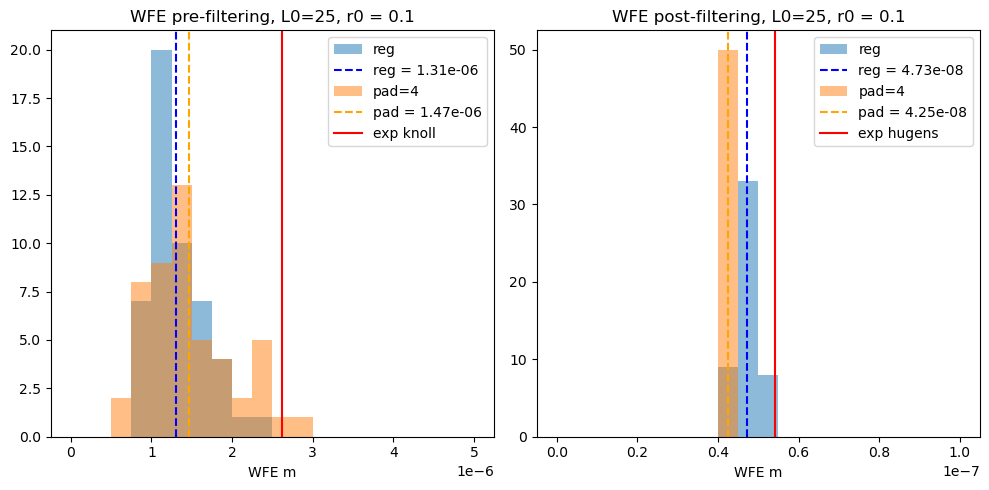

In [129]:
# compare the two:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

bins1 = np.linspace(0e-7, 50e-7, 21)
bins2 = np.linspace(0e-8, 10e-8, 21)

plt.sca(axs[0]) 
plt.title(f"WFE pre-filtering, L0={L0_test}, r0 = {r_o}")
#no padding
plt.hist(phase_WFE_list, bins=bins1, label = "reg", alpha = 0.5)
plt.axvline(np.mean(phase_WFE_list), c = "blue", ls='dashed', label=f'reg = {np.mean(phase_WFE_list):.3}')
#padding
plt.hist(phase_WFE_crop_list, bins=bins1, label = f"pad={pad}", alpha = 0.5)
plt.axvline(np.mean(phase_WFE_crop_list), c = f"orange", ls='dashed', label=f'pad = {np.mean(phase_WFE_crop_list):.3}')
plt.axvline(knoll, c="red", label="exp knoll")
plt.legend()
plt.xlabel("WFE m")

plt.sca(axs[1]) 
plt.title(f"WFE post-filtering, L0={L0_test}, r0 = {r_o}")
#no padding
plt.hist(phase_res_WFE_list, bins=bins2, label = "reg", alpha = 0.5)
plt.axvline(np.mean(phase_res_WFE_list), c = "blue", ls='dashed', label=f'reg = {np.mean(phase_res_WFE_list):.3}')
#padding
plt.hist(phase_res_WFE_crop_list, bins=bins2, label = f"pad={pad}", alpha = 0.5)
plt.axvline(np.mean(phase_res_WFE_crop_list), c = f"orange", ls='dashed', label=f'pad = {np.mean(phase_res_WFE_crop_list):.3}')
#expected
plt.axvline(hudgens,  c="red",  label="exp hugens")

plt.legend()
plt.xlabel("WFE m")

plt.tight_layout()
plt.show()

### Testing against power law

In [35]:
r_o = 0.1

phase_crop, phase_filt_crop, phase_res_crop = ts.turb_phase_padded_crop(r_o, grid, grid_pad, ff_pad, circ_ap_pad, h_reg, h_pad, ao_eff=1.0, sl=True)

In [36]:
wfe_res = 90e-9
# Regular surface aberration
sa2 = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3)
sa2_f = sa2.surface_sag - 1.0 * np.real(ff.forward(sa2.surface_sag + 0j))
sa2_f *= wfe_res / np.std(sa2_f[aperture>0])

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


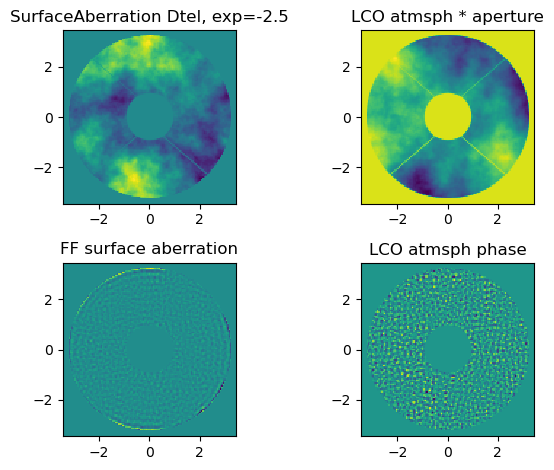

In [24]:
# checking LCO against power law
# might need to ork on supersamping
fig, axs = plt.subplots(nrows=2, ncols=2)

plt.sca(axs[0,0]) 
plt.title("SurfaceAberration Dtel, exp=-2.5")
imshow_field(sa2.surface_sag*aperture)

plt.sca(axs[1,0]) 
plt.title("FF surface aberration")
imshow_field(sa2_f*aperture)

plt.sca(axs[0,1]) 
plt.title("LCO atmsph * aperture")
imshow_field(phase_crop*aperture)

plt.sca(axs[1,1])  
plt.title("LCO atmsph phase")
imshow_field(phase_res_crop*aperture)

plt.tight_layout()
plt.show()

### PSFs

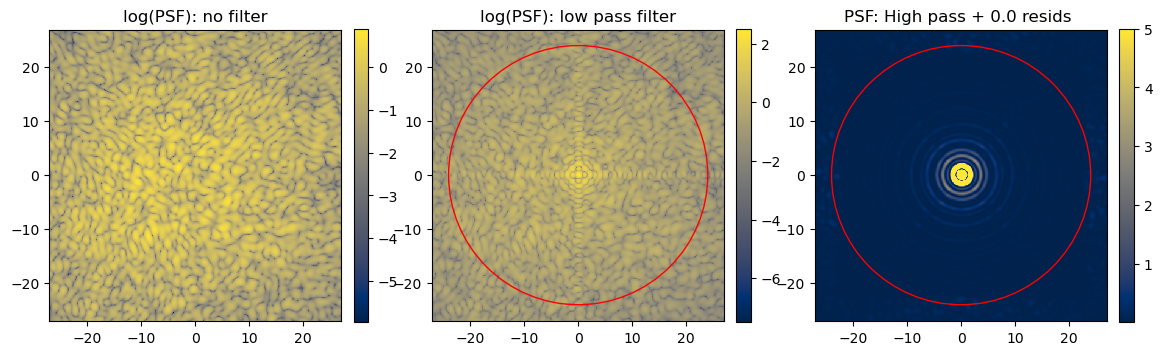

In [34]:
# want to check the fourier transform more speficially
fft = FastFourierTransform(grid, q=8, fov=0.5)

PSD = abs(fft.forward(np.exp(1j*phase_crop)*aperture))**2
PSD_filt = abs(fft.forward(np.exp(1j*phase_filt_crop*aperture)))**2
PSD_res = abs(fft.forward(np.exp(1j*phase_res_crop)*aperture))**2


fig = plt.figure(figsize=(14,5), facecolor='white')
# expected control region

plt.subplot(1,3,1)
plt.title("log(PSF): no filter")
imshow_field(np.log10(PSD), cmap='cividis')
plt.colorbar(fraction=0.046, pad=0.04)

#########################
plt.subplot(1,3,2)
plt.title("log(PSF): low pass filter")
imshow_field(np.log10(PSD_filt), cmap='cividis')
circle1 = plt.Circle((0, 0), 24, color='r', fill=False)
plt.gca().add_patch(circle1)
plt.colorbar(fraction=0.046, pad=0.04)

#############################
plt.subplot(1,3, 3)
plt.title("PSF: High pass + 0.0 resids ")
imshow_field(PSD_res, vmax=5, cmap='cividis')
circle2 = plt.Circle((0, 0), 24, color='r', fill=False)
plt.gca().add_patch(circle2)
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

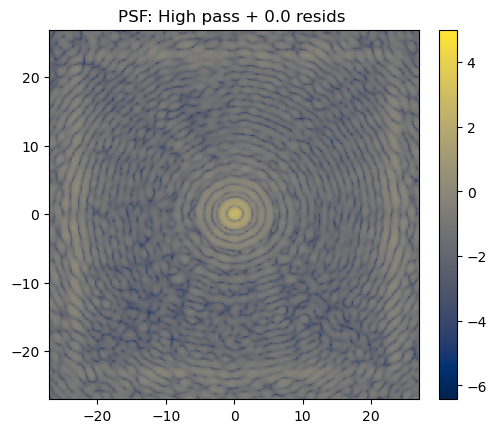

In [30]:
plt.title("PSF: High pass + 0.0 resids ")
imshow_field(np.log10(PSD_res), vmax=5, cmap='cividis')
#circle2 = plt.Circle((0, 0), 24, color='r', fill=False)
#plt.gca().add_patch(circle2)
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

In [27]:
np.sqrt(PSD_res.shape)

array([480.])

In [29]:
#actual PSDs
n = int(np.sqrt(PSD_res.shape))
mid = n//2
# create array of radii
x,y = np.meshgrid(np.arange(n),np.arange(n))
R = np.sqrt((x-mid)**2+(y-mid)**2)
r  = np.linspace(1,mid,num=mid)

# the 2d psds
PSD_2d = PSD.reshape((n,n))
PSD_2d_filt = PSD_filt.reshape((n,n))
PSD_2d_res = PSD_res.reshape((n,n))

# calculate the mean
f_psd = lambda r : PSD_2d[(R >= r-.5) & (R < r+.5)].mean()
mean_psd = np.vectorize(f_psd)(r)

f_filt = lambda r : PSD_2d_filt[(R >= r-.5) & (R < r+.5)].mean()
mean_filt = np.vectorize(f_filt)(r)

f_res = lambda r : PSD_2d_res[(R >= r-.5) & (R < r+.5)].mean()
mean_res = np.vectorize(f_res)(r)
r_x = np.linspace(0,48,num=mid)

/tmp/ipykernel_1725865/436397668.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(np.sqrt(PSD_res.shape))


#### PSD 2d

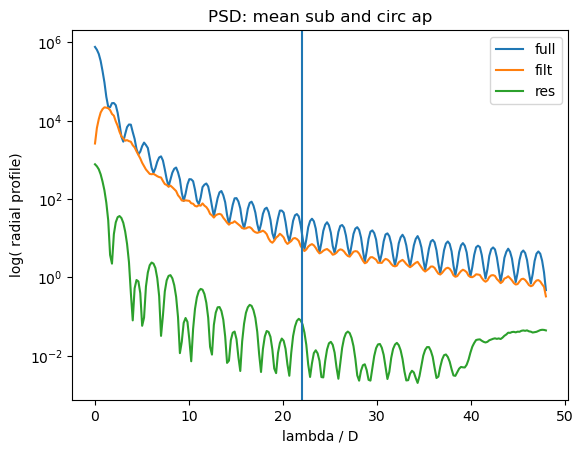

In [30]:
# plot it
fig,ax=plt.subplots()
plt.title("PSD: mean sub and circ ap")
ax.plot(r_x, mean_psd, label="full")
ax.plot(r_x, mean_filt, label="filt")
ax.plot(r_x, mean_res, label="res")
plt.axvline(22)
plt.yscale('log')
plt.xlabel('lambda / D')
plt.ylabel('log( radial profile)')
plt.legend()
plt.show()

In [31]:
# integrating with different bounds: 
dr = r_x[1] - r_x[0]
print(np.sum(2*np.pi*mean_filt[r_x > 22]*dr))
print(np.sum(2*np.pi*mean_res[r_x < 22]*dr))

# summing a vector along a radius, its 2*pi*r/dr

381.7158337056044
4055.974910088572


In [32]:
grid.shape

array([120, 120])

### Testing r_o metrics
turbulence simulation might not be returning simulation expected

In [21]:
# simplified aperture for minimizing funky ff residuals
Dtel = 6.5
Dgrid = 60/56 * Dtel
n_bin = 4 #this allows us to oversample our pupil
grid = make_pupil_grid(60*n_bin, Dgrid) # could suepersample this to stop aliasing errors
circ_ap = evaluate_supersampled(make_circular_aperture(Dtel), grid, 4)

# other setup variables
r_o = 0.10
lam_ro = 500e-9
lam_wfs = wavelength

In [ ]:
## SETTING UP profile
# create ml amospheric layers
layers = atmosphere.make_las_campanas_atmospheric_layers(grid, r0=r_o, wavelength=lam_ro) #set outer sclae to 500m 
ml_atmsph = atmosphere.MultiLayerAtmosphere(layers)
# Phase multiplied by telescope aperture
phase = ml_atmsph.phase_for(lam_wfs)

In [51]:
## SINGLE LAYER ATMOSPHERE - NOT WORKING
sl_atmsph = atmosphere.InfiniteAtmosphericLayer(grid, Cn_squared=atmosphere.Cn_squared_from_fried_parameter(r_o))
phase = sl_atmsph.phase_for(lam_wfs)

/opt/conda/lib/python3.10/site-packages/hcipy/atmosphere/atmospheric_model.py:352: RuntimeWarning: invalid value encountered in multiply
  return Field(a * b * c * d * e, grid)


ValueError: array must not contain infs or NaNs

In [ ]:
# this is the WFE of the generated phase
WFE_sim = ts.phase_to_WFE(phase[circ_ap>0], lam_wfs)

# can convert rad to r_o
WFE_sim_rad = ts.err_nm_to_rad(WFE_sim, lam_wfs)
ro_out = ts.variance_to_ro(WFE_sim_rad, Dtel, lam_ro, lam_wfs)

# these are the knoll literature values
WFE_lit = ts.ro_to_variance(0.1, Dtel, lam_ro, lam_wfs)
WFE_lit_nm = ts.err_rad_to_nm(WFE_lit, lam_wfs)

In [71]:
#compare 
print(f"Sim WFE: {WFE_sim*1e9:.3} nm")
print(f"Exp WFE: {WFE_lit_nm*1e9:.3} nm")
print(f"r_o input: {r_o} m")
print(f"r_o return: {ro_out:.3} m")

Sim WFE: 1.51e+03 nm
Exp WFE: 5.38e+04 nm
r_o input: 0.1 m
r_o return: 0.853 m


In [ ]:
# multiple phase trials:
r_o=0.005
sim_WFE = []
exp_r0_005 = []
for x in range(100):
    layers = atmosphere.make_las_campanas_atmospheric_layers(grid, r0=r_o, wavelength=lam_ro) 
    ml_atmsph = atmosphere.MultiLayerAtmosphere(layers)
    phase = ml_atmsph.phase_for(lam_wfs)
    # this is the WFE of the generated phase
    WFE_sim = ts.phase_to_WFE(phase[circ_ap>0], lam_wfs)
    # can convert rad to r_o
    WFE_sim_rad = ts.err_nm_to_rad(WFE_sim, lam_wfs)
    ro_out = ts.variance_to_ro(WFE_sim_rad, Dtel, lam_ro, lam_wfs)

    sim_WFE.append(WFE_sim)
    exp_r0_005.append(ro_out)

In [46]:
np.save("save/exp_r0_r005cm",exp_r0_005)

#### What does the LCO turbulence spit out?

In [30]:
exp_r0_10 = np.load("save/exp_r0_r10cm.npy")
exp_r0_05 = np.load("save/exp_r0_r05cm.npy")
exp_r0_01 = np.load("save/exp_r0_r01cm.npy")
exp_r0_005 = np.load("save/exp_r0_r005cm.npy")

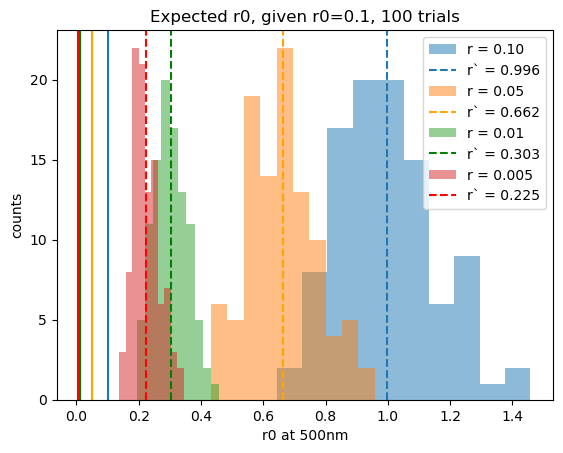

In [50]:
c_fact = 1

plt.title("Expected r0, given r0=0.1, 100 trials")
plt.hist(exp_r0_10, bins=10, label = "r = 0.10", alpha = 0.5)
plt.axvline(np.mean(exp_r0_10), ls='dashed', label=f'r` = {np.mean(exp_r0_10):.3}')

plt.hist(exp_r0_05, bins=10, label = "r = 0.05", alpha = 0.5)
plt.axvline(np.mean(exp_r0_05), c = "orange", ls='dashed', label=f'r` = {np.mean(exp_r0_05):.3}')

plt.hist(exp_r0_01, bins=10, label = "r = 0.01", alpha = 0.5)
plt.axvline(np.mean(exp_r0_01), c = "green", ls='dashed', label=f'r` = {np.mean(exp_r0_01):.3}')

plt.hist(exp_r0_005, bins=10, label = "r = 0.005", alpha = 0.5)
plt.axvline(np.mean(exp_r0_005), c = "red", ls='dashed', label=f'r` = {np.mean(exp_r0_005):.3}')

plt.ylabel("counts")
plt.xlabel("r0 at 500nm")
plt.legend()
plt.show()

[]

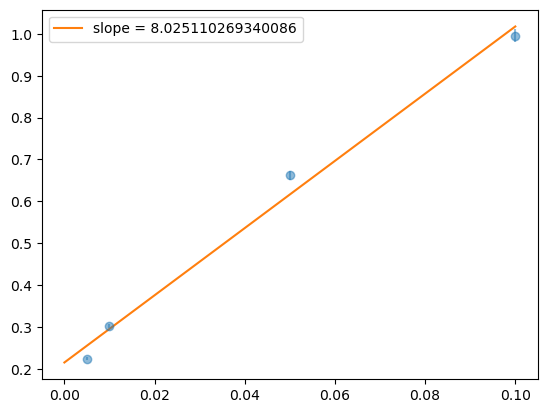

In [79]:
points = [0.1, 0.05, 0.01, 0.005]
means = [np.mean(exp_r0_10), np.mean(exp_r0_05), np.mean(exp_r0_01), np.mean(exp_r0_005)]
err = [np.std(exp_r0_10)/10, np.std(exp_r0_05)/10, np.std(exp_r0_01)/10, np.std(exp_r0_005)/10]

slope = np.polyfit(points,means,1)[0]
b = np.polyfit(points,means,1)[1]

plt.errorbar(points, means, err, ls='none', marker='o', alpha = 0.5)

plt.plot(np.linspace(0, 0.1, 10), slope*np.linspace(0, 0.1, 10) +b, label =f"slope = {slope}")

plt.legend()
plt.plot()


In [69]:
np.polyfit(points,means,1)[0]

8.025110269340086

## TRIAL 1: Probe vs Reconstruction
Testing the response curve

### Atmosphere trials

In [ ]:
### Phase screen parameters
trials = 50
r_o = 0.05 # what is this in dimm...

In [ ]:
##### Generating phase screens
phase_screens = []
phase_res_screens = []
for i in range(trials):
    # NOTE: AO filtering happening in phase screen generation!!
    phase, phase_filt, phase_res = ts.turb_phase_sl(r_o, grid, ff, circ_ap, ao_eff=0.98, L0=25)
    phase_screens.append(phase)
    phase_res_screens.append(phase_res)
# SAVE the trials
np.save(f"trials_n_{trials}_r0_{r_o}", phase_screens)
np.save(f"trials_res_n_{trials}_r0_{r_o}", phase_res_screens)

In [ ]:
### PULL PHASE SCREENS
phase_screens = np.load("save/trials_n_20_r0_0.1.npy") 

### WFS response, fixed turbulence strength

In [16]:
### MODES
# amplitude range
mode_index = np.array([0, 40 , 180]) #changed these from 41 and 181
amplitudes = np.linspace(0, 400e-9, 20) # poke amplitudes for the DM

# defining AO filtering
ffs = FourierFilter(grid, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)
circ_ap = evaluate_supersampled(make_circular_aperture(6.5), grid, 4)

In [ ]:
### Coefficients for LCO ABBERRATED COEFFICIENTS
num_iterations = trials
coef_LCO = np.zeros((mode_index.size, amplitudes.size, num_iterations))
WFE_LCO = np.zeros((mode_index.size, amplitudes.size, num_iterations))
#wfe_res = 40e-9

for k, mi in enumerate(mode_index):
	print(f"Starting mode: {mi}")
	for ai, amp in enumerate(amplitudes):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = amp
			# NOTE: AO filtering happening in phase screen generation!!
			abr = PhaseApodizer(phase_res_screens[i]*aperture)
			im = 0
			for wfi in mpwfs(abr(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)

			#coef[k, ai, i] = reconstruction_matrix.dot( im - Iref )[mi]
			#direct reconstructions:
			coef_LCO[k, ai, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
			WFE_LCO[k, ai, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)


Starting mode: 0


KeyboardInterrupt: 

In [ ]:
#### PURE COEFFICIENTS
dl_coef = np.zeros((mode_index.size, amplitudes.size))

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		dm.flatten()
		dm.actuators[mi] = amp

		im = 0
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#recondstruction matrix
		#dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
		#direct reconstruction:
		dl_coef[k, ai] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

In [ ]:
# save these probe vs rec
np.save("save/probe_v_rec_coef_nores", dl_coef)
np.save("save/probe_v_rec_coef_LCO_98", coef_LCO)
np.save("save/probe_v_rec_WFE_LCO_98", WFE_LCO)

### Plots, also reload

In [ ]:
#### LOAD OLD TRIALS
dl_coef = np.load("save/probe_v_rec_coef_nores.npy")
coef_LCO = np.load("save/probe_v_rec_coef_LCO_98.npy")
WFE_LCO = np.load("save/probe_v_rec_WFE_LCO_98.npy")

In [ ]:
np.median(WFE_LCO*1e9)

92.40450784510406

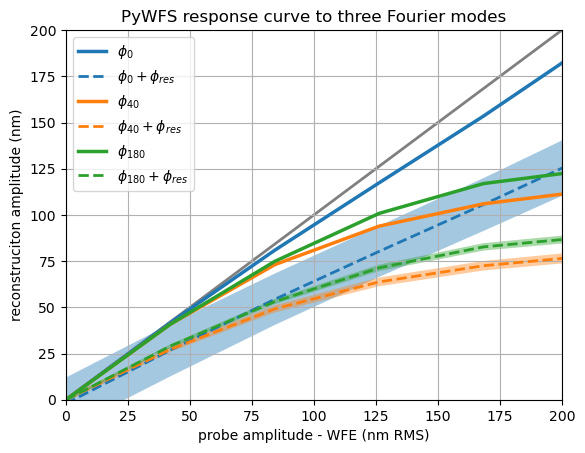

In [ ]:
# PAPER PLOT

#plt.axvline(2*calibration_amplitude/1e-9, label = 'calib amp', color = 'red')
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
for i in range(3):
	mean = 2*np.mean(coef_LCO, axis=2)[i] / 1e-9
	std = 2*np.std(coef_LCO, axis=2)[i] / 1e-9
	# dashed: average mode with errors
	plt.fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	plt.plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	# solid: default
	
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
plt.title(f"PyWFS response curve to three Fourier modes")
plt.xlabel("probe amplitude - WFE (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.ylim([0,200])
plt.xlim([0,200])
plt.legend()
plt.grid()

plt.savefig('../plots/OG_LCO_WFE_modes_zoom.png',dpi=300)

Residual WFE 234 nm


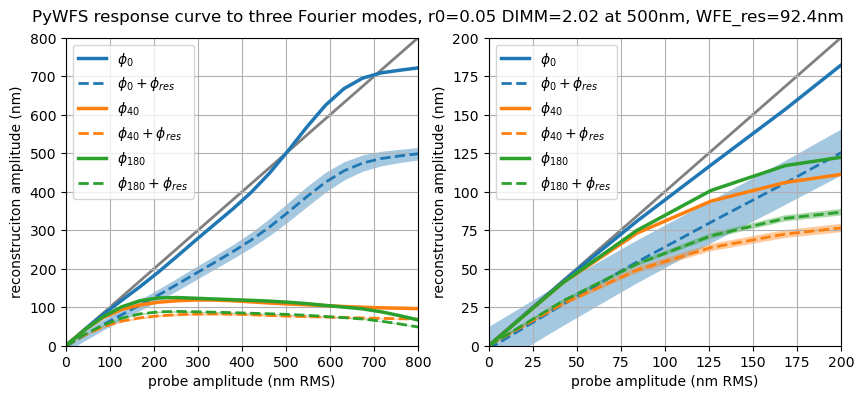

In [ ]:
# PAPER PLOT - 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4), facecolor='white')

amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
print(f"Residual WFE {(2*wfe_res/1e-9):0.0f} nm")

# SUBPLOT 1 - same as above
plt.suptitle(f"PyWFS response curve to three Fourier modes, r0={r_o:.3} DIMM={ro_to_seeing(r_o):.3} at 500nm, WFE_res={np.median(WFE_LCO*1e9):.3}nm ", y = 0.95)
axs[0].set_xlabel("probe amplitude (nm RMS)")
axs[0].set_ylabel("reconstruciton amplitude (nm)")

for i in range(3):
	mean = 2*np.mean(coef_LCO, axis=2)[i] / 1e-9
	std = 2*np.std(coef_LCO, axis=2)[i] / 1e-9
	# solid: default
	axs[0].plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	# dashed: average mode with errors
	axs[0].plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	axs[0].fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
# plotting the average line
axs[0].plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
axs[0].set_ylim([0,800])
axs[0].set_xlim([0,800])
axs[0].legend()
axs[0].grid()

# SUBPLOT 2 - first 100nm  WFE
axs[1].set_xlabel("probe amplitude (nm RMS)")
axs[1].set_ylabel("reconstruciton amplitude (nm)")

for i in range(3):
	mean = 2*np.mean(coef_LCO, axis=2)[i] / 1e-9
	std = 2*np.std(coef_LCO, axis=2)[i] / 1e-9
	# solid: default
	axs[1].plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
	# dashed: average mode with errors
	axs[1].plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	axs[1].fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
# plotting the average line
axs[1].plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
axs[1].set_ylim([0,200])
axs[1].set_xlim([0,200])
axs[1].legend()
axs[1].grid()

plt.savefig('../plots/OG_LCO_WFE_modes_zoom.png',dpi=300)

### Is OG flat?

Checking that the OG values follow the same line

/tmp/ipykernel_33837/1188826302.py:9: RuntimeWarning: divide by zero encountered in divide
  gain =  mean / (2*dl_coef[i, :])
/tmp/ipykernel_33837/1188826302.py:10: RuntimeWarning: divide by zero encountered in divide
  gain_std = std / (2*dl_coef[i, :])
/tmp/ipykernel_33837/1188826302.py:12: RuntimeWarning: invalid value encountered in add
  plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
/tmp/ipykernel_33837/1188826302.py:12: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)


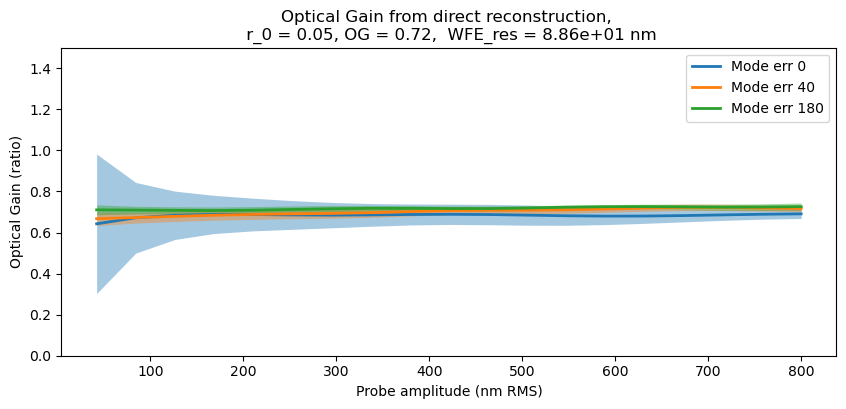

In [ ]:
# optical gain by ratio
#plt.axvline(calibration_amplitude/1e-9, label = 'calib amp')
fig = plt.figure( figsize=(10,4), facecolor='white')

for i in range(3):
	amps = 2*amplitudes/1e-9 # in WFE units, not DM surface
	mean = 2*np.mean(coef_LCO, axis=2)[i] 
	std = 2*np.std(coef_LCO, axis=2)[i]
	gain =  mean / (2*dl_coef[i, :])
	gain_std = std / (2*dl_coef[i, :])
	# dashed: average mode with errors
	plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amps, gain, lw=2, color='C{:d}'.format(i),  label='Mode err {:d}'.format(mode_index[i]))
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
plt.title(f"Optical Gain from direct reconstruction, \n r_0 = {r_o}, OG = {np.mean(gain[np.isfinite(gain)]):.2f},  WFE_res = {phase_to_WFE(abr.phase[aperture>0], wavelength)*1e9:.2e} nm")
plt.xlabel("Probe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.ylim([0, 1.5])
plt.legend()
plt.show()

## TRIAL 2: OG vs Resid WFE
iterate over the residual WFE

### Method 1: sampling WFE => r0 

In [ ]:
# can we change WFE to r_o for plotting?
trials = 20 # number per res
residuals = np.linspace(1e-11, 400e-9, 50) 
r_0_eq = np.array([ts.inv_hugens(res) for res in residuals]) # using hugens to approx r0 per WFE_res

In [ ]:
##### Generating phase screens
phase_screens_2 = []
phase_res_screens_2 = []
# how do I translate this to WFE?
for e, r0 in enumerate(r_0_eq):
    phase_temp = []
    phase_res_temp = []
    for i in range(trials):
        phase, phase_filt, phase_res = ts.turb_phase_sl(r0, grid, ff, circ_ap, ao_eff=0.98, L0=25)
        phase_temp.append(phase)
        phase_res_temp.append(phase_res)
    phase_screens_2.append(phase_temp)
    phase_res_screens_2.append(phase_res_temp)

# SAVE the trials
np.save(f"save/trials2_n_{trials}_maxres_400nm_L0_25", phase_screens_2)
np.save(f"save/trial2s_res_n_{trials}_maxres_nm_L0_25", phase_res_screens_2)

In [29]:
# LOAD the trials

phase_screens_2 = np.load(f"save/trials2_n_{trials}_maxres_400nm_L0_25.npy")
phase_res_screens_2 = np.load(f"save/trial2s_res_n_{trials}_maxres_nm_L0_25.npy")

In [ ]:
# optical gain by residual
num_iterations = trials
WFE_coef = np.zeros((mode_index.size, residuals.size, num_iterations))
WFE_LCO = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp
			#making sure the 
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				# NOTE: AO filtering happening in phase screen generation!!
				abr = PhaseApodizer(phase_res_screens_2[ri][i]*aperture)
				wf_prop = mpwfs(abr(dm((wf))))
			# modulated WFS
			im = 0
			for wfi in wf_prop:
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)

			#direct reconstruction:
			WFE_coef[k, ri, i] = slopes.T.dot(im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
			WFE_LCO[k, ri, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)

In [54]:
# calculate streh
residuals_wfe = residuals
strehl = np.exp(-(2*np.pi*residuals_wfe/wavelength)**2)

In [36]:
residuals_avg = np.mean(WFE_LCO[1:,:,:], axis=(0,2))
strehl_avg = np.exp(-(2*np.pi*residuals_avg/wavelength)**2)
strehl_avg_07= np.exp(-0.7*(2*np.pi*residuals_avg/wavelength)**2)
strehl_avg[0] = 1.0
strehl_avg_07[0] = 1.0

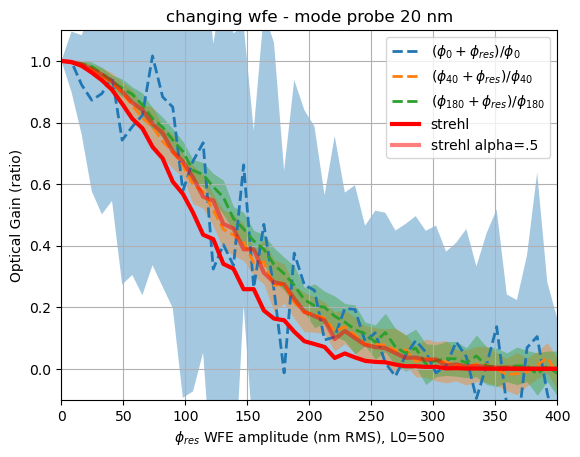

In [37]:
for i in range(3):
	mean = np.mean(WFE_coef, axis=2)[i] 
	std = np.std(WFE_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	plt.fill_between(residuals/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(residuals/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$(\phi_{{{mode_index[i]:d}}} + \phi_{{res}}) / \phi_{{{mode_index[i]:d}}} $')
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line
#plt.plot(residuals/1e-9, residuals/1e-9, color='gray', zorder=-1, lw=2)
plt.plot(residuals/1e-9, strehl_avg, color = 'red', label='strehl', lw = 3)
plt.plot(residuals/1e-9, strehl_avg_07, color = 'red', label='strehl alpha=.5', alpha=0.5, lw = 3)
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel(f'$\phi_{{res}}$ WFE amplitude (nm RMS), L0=500')
plt.ylabel("Optical Gain (ratio)")
plt.xlim(0, 400)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.savefig('../plots/OG_prove_wfe_SR.png',dpi=300)

/tmp/ipykernel_91341/767589451.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,i+1)


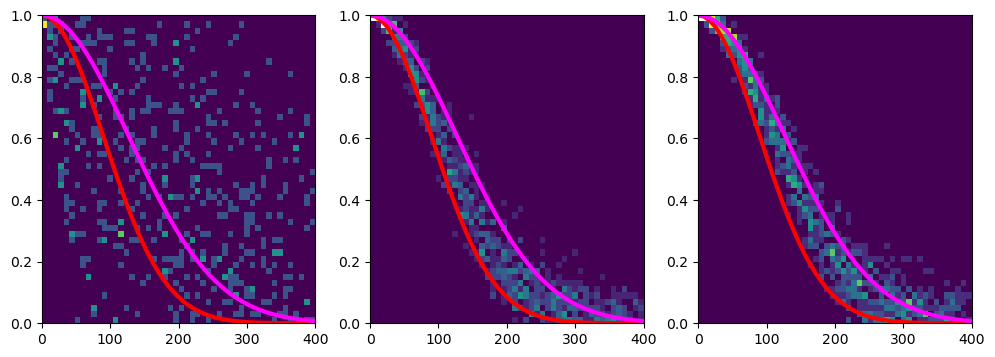

In [60]:
# could replot with OG vs. strehl  > line
fig = plt.figure(figsize=(12,4))
plt.title("Make this a histogram")
for i in range(3):
    WFE_mode_coef = np.array(WFE_coef[i, :, :]).flatten()
    WFE_mode_LCO = np.array(WFE_LCO[i, :, :]).flatten()
    plt.subplot(1,3,i+1)
    plt.hist2d(WFE_mode_LCO/1e-9, WFE_mode_coef / test_amp, bins = 50, range=[[0, 400],[0, 1]], cmin=0,cmax=10)
    plt.plot(residuals/1e-9, strehl, color = 'red', label='strehl', lw = 3)
    plt.plot(residuals/1e-9, np.sqrt(strehl), color = 'magenta', label='streh sqrt', lw = 3)

### Method 2: sampling from a powerlaw 

In [ ]:
def turb_phase_PL_WFE(wfe_res, circ_ap, aperture, ao_eff=1.0):
    ### TODO: DOESN"T WORK
    # Regular surface aberration
    sa2 = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3, refractive_index=2)
    phase = sa2.surface_sag ()
    #phase processing
    phase_ms = (phase - np.mean(phase[circ_ap>0])) # mean subtracted
    phase_filt = np.real(ff.forward(phase_ms + 0j)) # low pass filter
    phase_res = phase_ms - ao_eff * phase_filt # HP filter
    phase_res *= circ_ap 
    # scale to espected wfe
    phase_res *= wfe_res / np.std(phase_res[aperture>0])
    phase *=  wfe_res / np.std(phase_res[aperture>0])
    phase_filt *=  wfe_res / np.std(phase_res[aperture>0])

    return phase, phase_filt, phase_res


In [74]:
# optical gain by residual
num_iterations = 10
residuals = np.linspace(0, 200e-9, 25)
WFE_coef = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			#making sure the 
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				# NOTE: AO filtering happening in phase screen generation!!
				_, _, phase_res = turb_phase_PL_WFE(res, circ_ap, aperture)
				sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3)
				sa.surface_sag = phase_res
				wf_prop = mpwfs(abr(sa((wf))))

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in wf_prop:
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			WFE_coef[k, ri, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [78]:
WFE_coef

array([[[ 1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
          1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
          1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
          1.00000000e-08],
        [ 1.45180605e-09, -1.45212456e-09,  2.29242723e-09,
          7.16633305e-10,  1.46719131e-10,  2.22254364e-09,
         -1.52072218e-09,  3.40167861e-10, -9.70637178e-10,
          1.19266538e-09],
        [ 4.53095010e-10,  1.92111213e-09,  3.73110839e-10,
         -1.55360105e-09, -2.98018959e-10, -1.57710014e-09,
          1.21136791e-09,  1.41625487e-09, -1.75618391e-09,
         -2.39996828e-09],
        [ 2.15341681e-09,  1.68712199e-09,  6.25543180e-10,
          6.47092941e-10, -9.84401646e-10, -1.09365693e-09,
          1.60743714e-09,  6.89077055e-10,  5.61834179e-09,
         -1.58448939e-09],
        [-6.48415250e-10, -1.37187990e-10,  1.02739382e-09,
          7.77153641e-10,  4.76152108e-10,  6.49241086e-10,
          7.10128596e-10,  1.60126080e-09,  4.049249

In [ ]:
# optical gain by residual
num_iterations = 10
residuals = np.linspace(0, 200e-9, 25)
WFE_coef = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3)
			phase = sa.surface_sag
			#phase processing
			phase_ms = (phase - np.mean(phase[circ_ap>0])) # mean subtracted
			phase_filt = np.real(ff.forward(phase_ms + 0j)) # low pass filter
			phase_res = phase_ms - 0.98 * phase_filt # HP filter
			phase_res *= circ_ap 
			# putting back as a phase
			sa.surface_sag = phase_res
			sa.surface_sag *= res / (np.std(sa.surface_sag[aperture>0]))
			# now propagating a wavefront
			#abr = PhaseApodizer(phase_res*aperture)
			wf_prop = mpwfs(sa(dm((wf))))

			#wf_pwfs = pwfs(sa(dm(wf)))
			im = 0
			for wfi in wf_prop:
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			WFE_coef[k, ri, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [76]:
# calculate streh
residuals_wfe = 2*residuals
strehl = np.exp(-(2*np.pi*residuals_wfe/wavelength)**2)

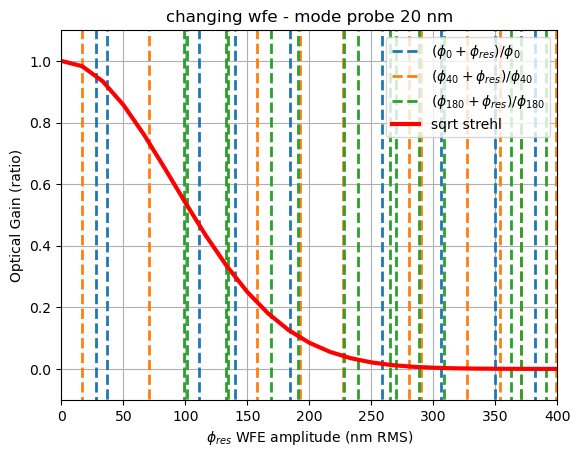

In [81]:
for i in range(3):
	mean = np.mean(WFE_coef, axis=2)[i] 
	std = np.std(WFE_coef, axis=2)[i] 
	gain = mean / test_amp /1e-9
	std_gain = std/test_amp *1e-9
	# dashed: average mode with errors
	plt.fill_between(residuals_wfe/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(residuals_wfe/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$(\phi_{{{mode_index[i]:d}}} + \phi_{{res}}) / \phi_{{{mode_index[i]:d}}} $')
	# solid: default
	#plt.plot(amplitudes/1e-9, dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label='Mode {:d}'.format(mode_index[i]), lw=2.5)
# plotting the average line 
#plt.plot(residuals/1e-9, residuals/1e-9, color='gray', zorder=-1, lw=2)
plt.plot(residuals_wfe/1e-9, strehl, color = 'red', label='sqrt strehl', lw = 3)
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel(f'$\phi_{{res}}$ WFE amplitude (nm RMS)')
plt.ylabel("Optical Gain (ratio)")
plt.xlim(0, 400)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.show()
#plt.savefig('../plots/OG_prove_wfe_SR.png',dpi=300)

## TRIAL 3: OG vs Modes 
Iter over all the modes at one poke WFE


### Method one: power law  

but the correct one

In [ ]:
# saving a power law phase
num_iterations = 5
residuals_test = np.array([0, 10e-9, 25e-9, 50e-9, 100e-9, 200e-9])

surf_sag_res = []

for i in range(num_iterations):
    sag_temp = []
    # create a surface
    sa =    (grid, wavelength, Dtel, exponent=-11/3)
    phase = sa.surface_sag
    # phase processing
    phase_ms = (phase - np.mean(phase[circ_ap>0])) # mean subtracted   
    phase_filt = np.real(ff.forward(phase_ms + 0j)) # low pass filter
    phase_res = phase_ms - 0.98 * phase_filt # HP filter
    phase_res *= circ_ap

    #plt.imshow(phase_res)

    for ri, res in enumerate(residuals_test):
        phase_res_tmp = phase_res
        phase_res_tmp *= res / (np.std(phase_res_tmp[aperture>0]))
        #print(np.std(phase_res_tmp))
        sag_temp.append(phase_res_tmp)
    surf_sag_res.append(sag_temp)


/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)
/tmp/ipykernel_1484019/4194122999.py:24: RuntimeWarning: divide by zero encountered in divide
  phase_res_tmp *= res / (np.std(phase_res_tmp[aperture>0]))
/tmp/ipykernel_1484019/4194122999.py:24: RuntimeWarning: invalid value encountered in multiply
  phase_res_tmp *= res / (np.std(phase_res_tmp[aperture>0]))


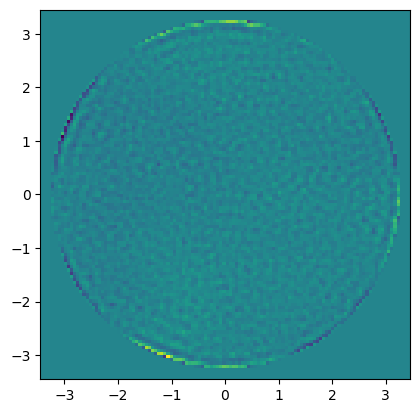

In [49]:
imshow_field(surf_sag_res[1][1])

In [ ]:
# OG by MODE
modes_tested = np.arange(0, 200, 10)
modes_iter_coef = np.zeros((residuals_test.size, modes_tested.size, num_iterations))
test_amp = 10e-9

for i in range(num_iterations):
	sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3)
	phase = sa.surface_sag
	#phase processing
	phase_ms = (phase - np.mean(phase[circ_ap>0])) # mean subtracted
	phase_filt = np.real(ff.forward(phase_ms + 0j)) # low pass filter
	phase_res = phase_ms - 0.98 * phase_filt # HP filter
	phase_res *= circ_ap 

	for ri, res in enumerate(residuals_test):
		sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-11/3)
		# putting back as a phase
		sa.surface_sag = phase_res
		sa.surface_sag *= res / (np.std(sa.surface_sag[aperture>0]))
		# test each mode

		for k, mi in enumerate(modes_tested):
		
			dm.flatten()
			dm.actuators[mi] = test_amp

			# now propagating a wavefront
			wf_prop = mpwfs(sa(dm((wf))))

			im = 0
			for wfi in wf_prop:
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			modes_iter_coef[ri, k, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

/opt/conda/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


/tmp/ipykernel_1484019/3605918302.py:21: RuntimeWarning: divide by zero encountered in divide
  sa.surface_sag *= res / (np.std(sa.surface_sag[aperture>0]))
/tmp/ipykernel_1484019/3605918302.py:21: RuntimeWarning: invalid value encountered in multiply
  sa.surface_sag *= res / (np.std(sa.surface_sag[aperture>0]))


In [24]:
np.save("save/modes_iter_coef_113", modes_iter_coef)

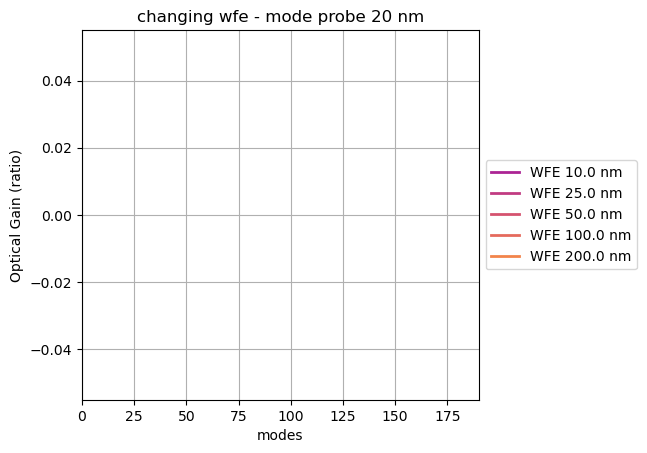

In [30]:
# plot: jsut the Mode to OG value
fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

for i in range(1,len(residuals_test)):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# dashed: average mode with errors
	ax.fill_between(modes_tested, gain - std_gain, gain + std_gain,  alpha=0.4, lw=0, color=colors[i])
	ax.plot(modes_tested, gain, lw=2, ls ='-', label=f'WFE {residuals_test[i]/1e-9 :0.4} nm',  c=colors[i])
	# solid: default
	
# plotting the average line
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel("modes")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.xlim(0,190)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.savefig('../plots/OG_vs_modes_113',dpi=300)

In [31]:
modes_iter_coef[1]

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

### Method 2: Generate atmospheric turbulence

In [ ]:
# need to generate 50 trials per 

# how do I translate this to WFE?
for e, r0 in enumerate(r_0_eq):
    phase_temp = []
    phase_res_temp = []
    for i in range(trials):
        phase, phase_filt, phase_res = turb_phase_sl(r0, grid, ff, circ_ap, ao_eff=0.98, L0=25)
        phase_temp.append(phase)
        phase_res_temp.append(phase_res)
    phase_screens_2.append(phase_temp)
    phase_res_screens_2.append(phase_res_temp)

In [ ]:



# iter over ri, k, i

for ri, res in enumerate(residuals_test):
	for k, mi in enumerate(modes_tested):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			# now propagating a wavefront
			wf_prop = mpwfs(sa(dm((wf))))
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				# NOTE: AO filtering happening in phase screen generation!!
				abr = PhaseApodizer(phase_res_screens_2[ri][i]*aperture)
				wf_prop = mpwfs(abr(dm((wf))))

### FINALLY: Combine the last two plots for the paper

In [34]:
residuals_test = np.array([0, 10e-9, 25e-9, 50e-9, 100e-9, 200e-9])

# calculate streh
residuals = np.linspace(0, 200e-9, 25)
residuals_wfe = 2*residuals
strehl = np.exp(-(2*np.pi*residuals_wfe/wavelength)**2)

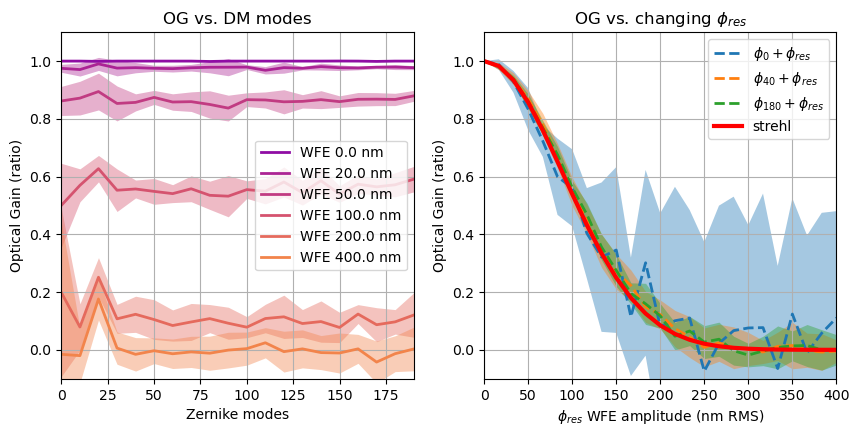

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs[0].set_title(f"OG vs. DM modes")
axs[0].set_xlabel("Zernike modes")
axs[0].set_ylabel("Optical Gain (ratio)")
#plot for each resifual
for i in range(len(residuals_test)):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	axs[0].fill_between(modes_tested, gain - std_gain, gain + std_gain, color=colors[i], alpha=0.4, lw=0)
	axs[0].plot(modes_tested, gain, lw=2, c=colors[i], label=f'WFE {2*residuals_test[i]/1e-9 :0.4} nm')
	# solid: default
axs[0].set_xlim(0, 190)
axs[0].set_ylim(-0.1, 1.1)
axs[0].legend()
axs[0].grid()

# SUBPLOT 2: Showing the relationship to strehl
for i in range(3):
	mean = np.mean(WFE_coef, axis=2)[i] 
	std = np.std(WFE_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	axs[1].fill_between(residuals_wfe/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	axs[1].plot(residuals_wfe/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')

axs[1].plot(residuals_wfe/1e-9, strehl, color = 'red', label='strehl', lw = 3)
axs[1].set_title(f"OG vs. changing $\phi_{{res}}$")
axs[1].set_xlabel(f"$\phi_{{res}}$ WFE amplitude (nm RMS)")
axs[1].set_ylabel("Optical Gain (ratio)")
axs[1].set_xlim(0, 400)
axs[1].set_ylim(-0.1, 1.1)
axs[1].legend()
axs[1].grid()


plt.savefig('../plots/OG_vs_mode_vs_SR.png',dpi=300)

## LCO turbulence
Retrying the last plot but now iter over turbulence. 

In [59]:
# I need to generate the turbulence screens beforehand. 
##### Generating phase screens
num_iterations = 20
r_o_test = np.array([0.20, 0.15, 0.12, 0.1, 0.08, 0.05])
modes_tested = np.arange(0, 200, 10)
test_amp = 10e-9
phase_screens_og = []
# how do I translate this to WFE?

for ri, r0 in enumerate(r_o_test):
	phase_tmp = []
	for i in range(num_iterations):
		layers = atmosphere.make_las_campanas_atmospheric_layers(grid, r0=r0)
		ml_atmsph = atmosphere.MultiLayerAtmosphere(layers)
		phase = ml_atmsph.phase_for(wavelength)
		phase_tmp.append(phase)
	phase_screens_og.append(phase_tmp)

In [61]:
# OG by MODE
# 9.18.2024 - redoing previous plots with chosen R-o values
modes_iter_r0 = np.zeros((r_o_test.size, modes_tested.size, num_iterations))
for ri, r0 in enumerate(r_o_test):
	for k, mi in enumerate(modes_tested):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp

			phase = phase_screens_og[ri][i]
			phase_res = phase - 0.98 * np.real(ff.forward(phase + 0j)) # HP filter

			abr = PhaseApodizer(phase_res*aperture)
			im = 0
			for wfi in mpwfs(abr(dm((wf)))):
				im += wfi.power
			im /= 20
			im_binned = subsample_field(im, n_bin)
			#direct reconstruction:
			modes_iter_r0[ri, k, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
	print("finished ro: ", r0)

finished ro:  0.2
finished ro:  0.15
finished ro:  0.12
finished ro:  0.1
finished ro:  0.08
finished ro:  0.05


In [ ]:
# plot: jsut the Mode to OG value
fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(r_o_test)))

for i in range(len(r_o_test)):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# dashed: average mode with errors
	ax.fill_between(modes_tested, gain - std_gain, gain + std_gain,  alpha=0.4, lw=0, color=colors[i])
	ax.plot(modes_tested, gain, lw=2, ls ='-', label=f'r_o {r_o_test[i]/1e-9 :0.4} nm',  c=colors[i])
	# solid: default
	
# plotting the average line
plt.title(f"changing wfe - mode probe {(2*test_amp/1e-9):0.0f} nm")
plt.xlabel("modes")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.xlim(0,190)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.savefig('../plots/OG_vs_modes',dpi=300)

In [ ]:
# for the next plot, I have to keep track of WFE and pake sure to log it per image

### SelfRM spoof

Checking all the calibration values

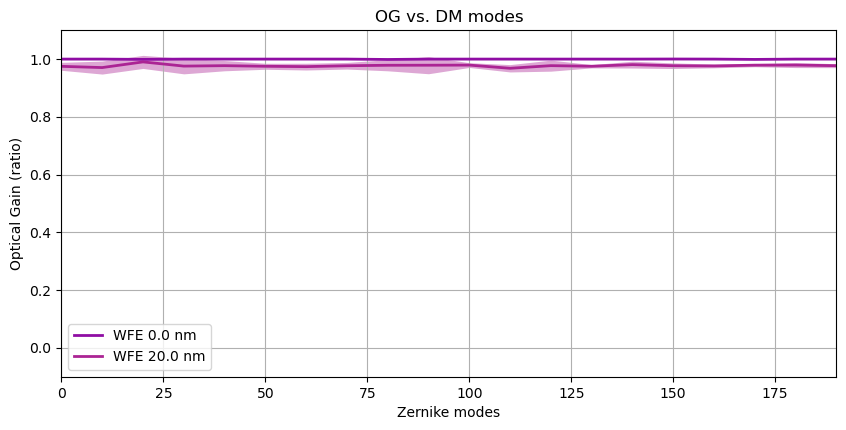

In [44]:
## checking our lab cal amplitudes (like a selfRM)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs.set_title(f"OG vs. DM modes")
axs.set_xlabel("Zernike modes")
axs.set_ylabel("Optical Gain (ratio)")
#plot for each resifual
for i in range(2):
	mean = np.mean(modes_iter_coef, axis=2)[i] 
	std = np.std(modes_iter_coef, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std/test_amp
	# dashed: average mode with errors
	axs.fill_between(modes_tested, gain - std_gain, gain + std_gain, color=colors[i], alpha=0.4, lw=0)
	axs.plot(modes_tested, gain, lw=2, c=colors[i], label=f'WFE {2*residuals_test[i]/1e-9 :0.4} nm')
	# solid: default
axs.set_xlim(0, 190)
axs.set_ylim(-0.1, 1.1)
axs.legend()
axs.grid()

## Trucate:  OG vs. Modes

Doing the same thing as before, now truncated

In [1]:
# OG by MODE
modes_tested = np.arange(0, 200, 1)
test_amp = 10e-9

# the non truncated system
modes_coef = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #direct reconstruction:
    modes_coef[k] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

NameError: name 'dm' is not defined

In [50]:
reconstruction_matrix = inverse_tikhonov(slopes,1e-1)

In [51]:
#### TRUNC PURE COEFFICIENTS
reconstruction_matrix = inverse_tikhonov(slopes,1e-1)

trnc_modes_coef = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #recondstruction matrix
    #dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
    #direct reconstruction:
    trnc_modes_coef[k] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

In [53]:
#### TRUNC PURE COEFFICIENTS
reconstruction_matrix = inverse_tikhonov(slopes,5e-2)

trnc_modes_coef_05 = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #recondstruction matrix
    #dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
    #direct reconstruction:
    trnc_modes_coef_05[k] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

In [56]:
#### TRUNC PURE COEFFICIENTS
reconstruction_matrix = inverse_tikhonov(slopes,1e-2)

trnc_modes_coef_01 = np.zeros((modes_tested.size))

for k, mi in enumerate(modes_tested):
    dm.flatten()
    dm.actuators[mi] = test_amp

    im = 0
    for wfi in mpwfs(dm(wf)):
        im += wfi.power
    im /= 20
    im_binned = subsample_field(im, n_bin)

    #recondstruction matrix
    #dl_coef[k, ai] = reconstruction_matrix.dot( im - Iref )[mi]
    #direct reconstruction:
    trnc_modes_coef_01[k] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi] 

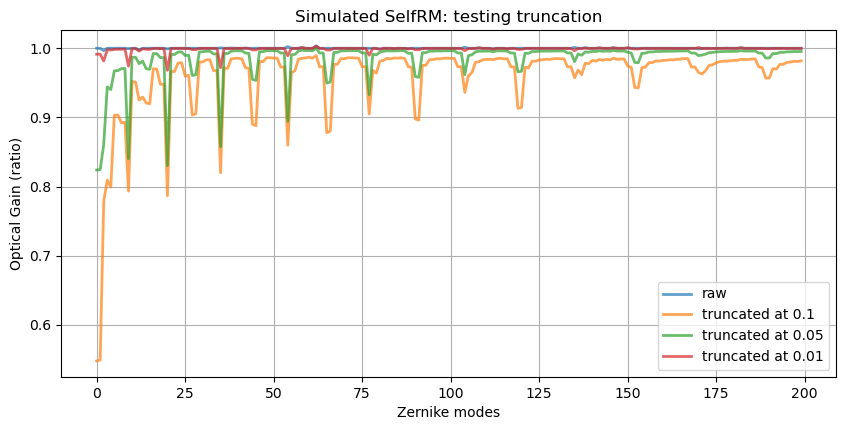

In [60]:
## checking our lab cal amplitudes (like a selfRM)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs.set_title(f"Simulated SelfRM: testing truncation")
axs.set_xlabel("Zernike modes")
axs.set_ylabel("Optical Gain (ratio)")

# dashed: average mode with errors
axs.plot(modes_tested, modes_coef/test_amp, lw=2, label="raw", alpha=0.7)
axs.plot(modes_tested, trnc_modes_coef/test_amp, lw=2, label="truncated at 0.1", alpha=0.7)
axs.plot(modes_tested, trnc_modes_coef_05/test_amp, lw=2, label="truncated at 0.05", alpha=0.7)
axs.plot(modes_tested, trnc_modes_coef_01/test_amp, lw=2, label="truncated at 0.01", alpha=0.7)

#solid: default
#axs.set_xlim(0, 190)
#axs.set_ylim(-0.1, 1.1)
axs.legend()
axs.grid()

#### These will divide out
Now will show a simulated on sky selfRM will divide out


In [62]:
#### TRUNCATED - ABBERRATED COEFFICIENTS
num_iterations = 10
wfe_res = 20e-9

trnc_modes_dl_coef_05 = np.zeros((modes_tested.size, num_iterations))

reconstruction_matrix = inverse_tikhonov(slopes,5e-2)

for k, mi in enumerate(modes_tested):
	for i in range(num_iterations):
		dm.flatten()
		dm.actuators[mi] = test_amp

		sa = SurfaceAberration(grid, wavelength, Dtel, exponent=-2.5)
		sa.surface_sag = sa.surface_sag - 0.98 * np.real(ff.forward(sa.surface_sag + 0j))
		sa.surface_sag *= wfe_res / np.std(sa.surface_sag[aperture>0])

		#wf_pwfs = pwfs(sa(dm(wf)))
		im = 0
		for wfi in mpwfs(sa(dm((wf)))):
			im += wfi.power
		im /= 20
		im_binned = subsample_field(im, n_bin)

		#direct reconstructions:
		trnc_modes_dl_coef_05[k, i] = reconstruction_matrix.dot( im_binned - Iref_bin )[mi]

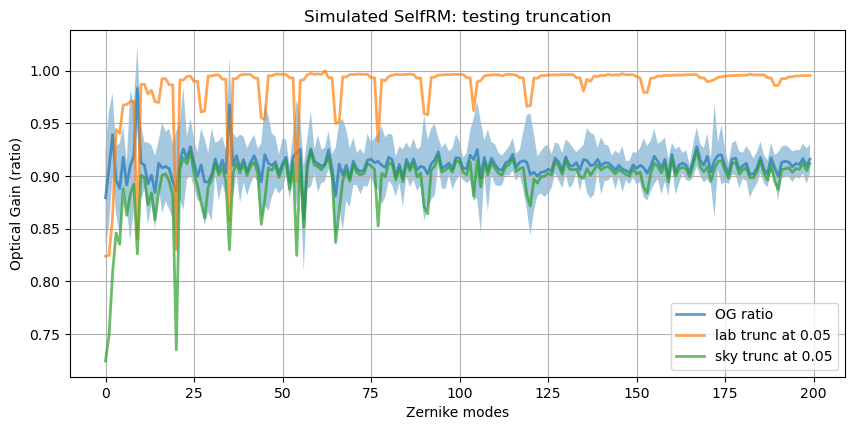

In [76]:
## checking our lab cal amplitudes (like a selfRM)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4.5), facecolor='white')

colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

# SUBPLOT 1: Showing flat residuals across modes
axs.set_title(f"Simulated SelfRM: testing truncation")
axs.set_xlabel("Zernike modes")
axs.set_ylabel("Optical Gain (ratio)")

mean = np.mean(trnc_modes_dl_coef_05, axis=1)
std = np.std(trnc_modes_dl_coef_05, axis=1)
gain = mean / trnc_modes_coef_05
std_gain = std / test_amp


axs.fill_between(modes_tested, gain - std_gain, gain + std_gain, alpha=0.4, lw=0)
axs.plot(modes_tested, gain, lw=2, label="OG ratio", alpha=0.7)

# dashed: average mode with errors
axs.plot(modes_tested, trnc_modes_coef_05/test_amp, lw=2, label="lab trunc at 0.05", alpha=0.7)
axs.plot(modes_tested, mean/test_amp, lw=2, label="sky trunc at 0.05", alpha=0.7)


axs.legend()
axs.grid()

In [74]:
std_gain.shape

(200,)